In [14]:
import pandas as pd
from pathlib import Path
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

In [3]:
bridge_df = pd.read_csv("cleaned_bridge_data.csv")

priority_df = pd.read_csv("priority_bridges.csv")
bridge_df

,Bridge_ID,Latitude,Longitude,Year_Built,Bridge_Condition,Average Daily_Traffic,Deck_Width,Structure_Length,SqFt,Repair_Cost_Est,Replacement_Cost_Est,Address
0,452997,40.103450,-74.961092,1990,Good,9729,13.0,18.3,237.90,"$50,796.41","$74,700.60","Dunksferry Road, Mechanicsville, 19020"
1,466574,40.017092,-75.211428,1928,Fair,14596,19.2,32.9,631.68,"$134,876.31","$198,347.52","Ridge Avenue, Wissahickon, 19127"
2,466580,39.963467,-75.186778,1964,Poor,27042,16.1,167.0,2688.70,"$574,091.22","$844,251.80","Spring Garden Street, Mantua, 19104"
3,466581,39.963861,-75.185025,1964,Poor,27042,16.2,27.1,439.02,"$93,739.55","$137,852.28","2917, Spring Garden Street, Mantua, 19104"
4,466617,40.035356,-75.208878,1957,Fair,28301,20.7,115.2,2384.64,"$509,168.33","$748,776.96","Henry Avenue, 19127"
...,...,...,...,...,...,...,...,...,...,...,...,...
153,471580,39.958900,-75.170372,2017,Good,8800,19.8,29.9,592.02,"$126,408.11","$185,894.28","North 19th Street, Center City, 19132"
154,471996,39.959400,-75.173906,2018,Good,13020,20.4,39.0,795.60,"$169,876.51","$249,818.40","Vine Street Expressway, Center City, 19103"
155,471998,39.959500,-75.175500,2018,Good,12400,25.5,32.9,838.95,"$179,132.60","$263,430.30","North 22nd Street, Center City, 19103"
156,472287,39.960194,-75.159694,1892,Poor,150,4.8,17.1,82.08,"$17,525.72","$25,773.12","Noble Street, Chinatown, Center City, 19123"


In [4]:
#Filter the data frame to get the traffic volume and coordinates for only the poor condition bridges

poor_traffic = bridge_df.loc[bridge_df["Bridge_Condition"] == "Poor", ["Latitude", "Longitude", "Bridge_Condition", "Average Daily_Traffic"]]

# poor_traffic

In [5]:
myMap = folium.Map(location = (39.952583, -75.165222), tiles = "OpenStreetMap", zoom_start = 11)

#Create a function to assign differnet colors dependant on the amount of ADT on each bridge

def get_circle_color(value):
    if value <= 5000:
        return 'green'
    elif value >= 5001 and value < 10000:
        return 'orange'
    else:
        return 'red'

#Create a group for the traffic volume cirlces

traffic_volume = folium.FeatureGroup(name = "Traiffic Volume", show=False ) 

#Add circles to the map for each poor condition bridge reflecting their traffic volume

for index, row in poor_traffic.iterrows():
    # Get the value for the circle color from the ADT column
    value = row["Average Daily_Traffic"]

    # Determine the color based on the value ranges
    color = get_circle_color(value)

    # Add a circle to the map with the determined color
    marker = folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]], 
        color=color,
        fill_color=color,
        fill_opacity=0.7,
        radius=10).add_to(traffic_volume)

# Create a function to assign different colors for the three different condition grades    

condition = bridge_df["Bridge_Condition"]
def get_marker_color(condition):
    if condition == "Good":
        return "green"
    elif condition == "Fair":
        return "orange" 
    else:
        return "darkred"

#Create separate groups for each marker type
good_group = folium.FeatureGroup(name="Good Condition")
fair_group = folium.FeatureGroup(name="Fair Condition")
poor_group = folium.FeatureGroup(name="Poor Condition")

#Create a group for the priority bridge markers
priority_bridges = folium.FeatureGroup(name = "Priority Bridges", show=False )

#Markers
for index, row in bridge_df.iterrows():
    ID = row["Bridge_ID"]
    lat = row["Latitude"]
    long = row["Longitude"]
    condition = row["Bridge_Condition"]
    address = row["Address"]
    avg_daily_traffic = row["Average Daily_Traffic"]
    repair_cost = row["Repair_Cost_Est"]
    replace_cost = row["Replacement_Cost_Est"]
    #Marker Coloring
    marker_color = get_marker_color(condition)
    text = f"ID: {ID} <br>Address: {address} <br>Latitude: {lat} <br>Longitude: {long} <br> Condition: {condition} <br> Average Daily Traffic: {avg_daily_traffic} <br> Estimated Cost to Repair: {repair_cost} <br> Estimated Cost to Replace: {replace_cost}"
    popup = folium.Popup(text, max_width = 300)
    marker = folium.Marker([lat, long], popup=popup, icon=folium.Icon(color=marker_color))
    
    if condition == "Good":
        marker.add_to(good_group)
    elif condition == "Fair":
        marker.add_to(fair_group)
    elif condition == "Poor":
        marker.add_to(poor_group)
    else:
        marker.add_to(myMap)

#Priority Markers
for index, row in priority_df.iterrows():
    ID = row["Bridge_ID"]
    lat = row["Latitude"]
    long = row["Longitude"]
    condition = row["Bridge_Condition"]
    address = row["Address"]
    avg_daily_traffic = row["Average Daily_Traffic"]
    repair_cost = row["Repair_Cost_Est"]
    replace_cost = row["Replacement_Cost_Est"]
    #Marker Coloring
    marker_color = get_marker_color(condition)
    text = f"ID: {ID} <br>Address: {address} <br>Latitude: {lat} <br>Longitude: {long} <br> Condition: {condition} <br> Average Daily Traffic: {avg_daily_traffic} <br> Estimated Cost to Repair: {repair_cost} <br> Estimated Cost to Replace: {replace_cost}"
    popup = folium.Popup(text, max_width = 300)
    Pmarker = folium.Marker([lat, long], popup=popup, icon=folium.Icon(color="darkred")).add_to(priority_bridges)
    
        # Add a circle to the map with the determined color
    PCmarker = folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]], 
        color="red",
        fill_color="red",
        fill_opacity=0.7,
        radius=10).add_to(priority_bridges)
        
good_group.add_to(myMap)
fair_group.add_to(myMap)
poor_group.add_to(myMap)
traffic_volume.add_to(myMap)
priority_bridges.add_to(myMap)

folium.LayerControl().add_to(myMap)

myMap

In [6]:
# Create function to turn amount into currency format
def format_currency(amount):
    return '${:,.2f}'.format(amount)

In [7]:
# Find sum of repair costs for poor bridges with high traffic
sum_repair = priority_df['Repair_Cost_Est'].sum()
format_currency(sum_repair)

'$2,885,840.23'

In [8]:
# Find sum of replacement costs for poor bridges with high traffic
sum_replace = priority_df['Replacement_Cost_Est'].sum()
format_currency(sum_replace)

'$4,243,882.70'

In [9]:
# Find average of repair costs for poor bridges with high traffic
avg_repair = priority_df['Repair_Cost_Est'].mean()
format_currency(avg_repair)

'$192,389.35'

In [10]:
# Find average of replacement costs for poor bridges with high traffic
avg_replace = priority_df['Replacement_Cost_Est'].mean()
format_currency(avg_replace)

'$282,925.51'

In [11]:
# Calculate difference between sum
difference = sum_replace - sum_repair
format_currency(difference)

'$1,358,042.47'

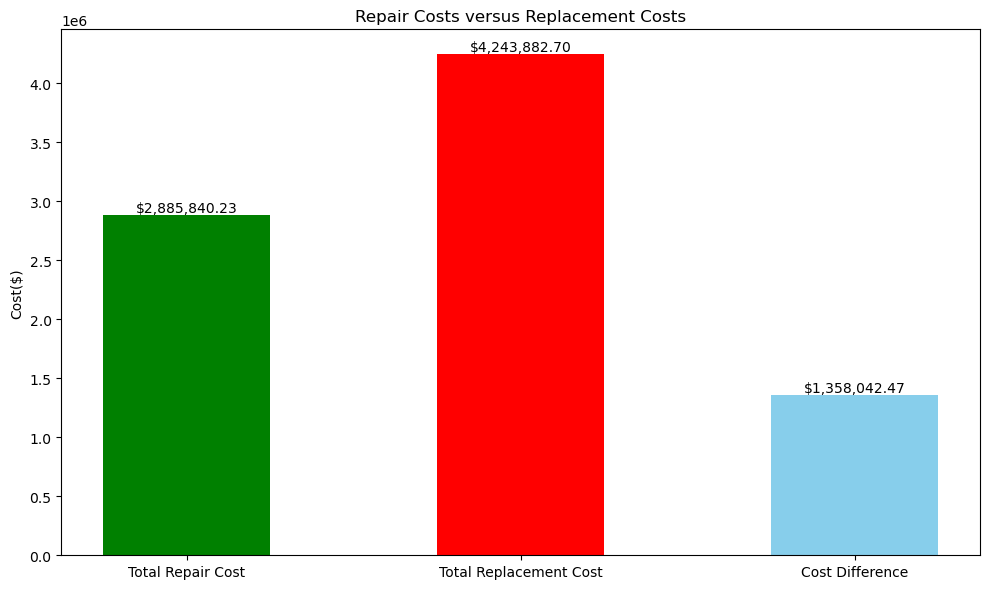

In [12]:
# Create bar of costs and difference
labels = ['Total Repair Cost', 'Total Replacement Cost', 'Cost Difference']
values = [sum_repair, sum_replace, difference]
x_pos = np.arange(len(labels))
plt.figure(figsize=(10,6))
bars = plt.bar(labels, values, color=['green', 'red', 'skyblue'], width=0.5)
plt.title('Repair Costs versus Replacement Costs')
plt.ylabel('Cost($)')
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), format_currency(value),
             ha='center', va='bottom', color='black', fontsize=10)
plt.xticks(x_pos, labels, rotation=0)
plt.tight_layout()
plt.show()